In [1]:
import janusrot
import os
import timeit
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
from scipy.signal import argrelmax,find_peaks,argrelmin
import imp
from scipy.sparse import csr_matrix
plt.rcParams.update({'font.size': 12, 'pdf.fonttype':42,'text.usetex': False, 'font.family': 'serif'})
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

imp.reload(janusrot)

<module 'janusrot' from '/Users/zack/Documents/oscillators/snakingoscillators/janusrot.py'>

### Find a limit-cycle chimera state

In [5]:
filebase='data/chimera/'
if not os.path.isdir(filebase):
    os.mkdir(filebase)
N=16
k=1
t1=10000
t3=9000
dt=0.01
sigma=0.35
beta=0.25
gamma=0.1
output=2
seed=10
omega=1

janusrot.runsim(N, t1, t3, dt, omega, beta, sigma, gamma, seed, filebase, output)
order=np.load(filebase+'order.npy')
phases=np.load(filebase+'phases.npy')
fs=np.load(filebase+'fs.npy')

using random initial conditions
data/chimera/ 0.536449382337348
runtime: 31.917229


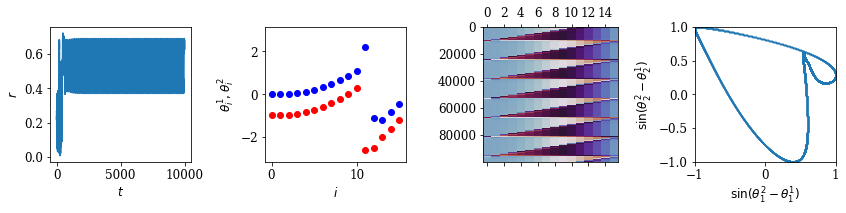

In [6]:
rho0=phases[:,N-1:2*(N-1)]**2+phases[:,:N-1]
rho1=phases[:,2*(N-1)+N:]**2+phases[:,2*(N-1):2*(N-1)+N]**2
phi0=np.concatenate([np.array([np.zeros(len(phases))]).T,np.arctan2(phases[:,N-1:2*(N-1)],phases[:,:N-1])],axis=1)
phi1=np.arctan2(phases[:,2*(N-1)+N:],phases[:,2*(N-1):2*(N-1)+N])

plt.subplots(1,4,figsize=(12,3))
plt.subplot(1,4,1)
plt.xlabel('$t$')
plt.ylabel('$r$')
plt.plot(order[0],order[1])
plt.subplot(1,4,2)
plt.xlabel('$i$')
plt.ylabel(r'$\theta_i^1, \theta_i^2$')
plt.ylim(-np.pi,np.pi)
plt.plot(phi0[-1],'bo')
plt.plot(phi1[-1],'ro')
plt.subplot(1,4,3)
ratio=N/len(phases)
plt.gca().matshow(phi1,aspect=ratio,vmin=-np.pi,vmax=np.pi,cmap='twilight_shifted')
plt.subplot(1,4,4)
plt.xlabel(r'$\sin(\theta_1^2-\theta_1^1)$')
plt.ylabel(r'$\sin(\theta_2^2-\theta_2^1)$')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.scatter(np.cos(phi1[:,0]-phi0[:,0]),np.cos(phi1[:,1]-phi0[:,1]),s=0.1)
plt.tight_layout()
plt.show()

### We can solve a boundary value problem to find a limit cycle. We may improve convergence by defining the Jacobian.

In [18]:
filebase='data/chimera/'
if not os.path.isdir(filebase):
    os.mkdir(filebase)
N=16
k=1
t1=10000
t3=9000
dt=0.25
sigma0=0.35
beta=0.25
gamma=0.1
output=2
seed=10
omega=1

janusrot.runsim(N, t1, t3, dt, omega, beta, sigma0, gamma, seed, filebase, output)
order=np.load(filebase+'order.npy')
phases=np.load(filebase+'phases.npy')
fs=np.load(filebase+'fs.npy')

using random initial conditions
data/chimera/ 0.5364531180992091
runtime: 29.899936


(62, 570) 142.5


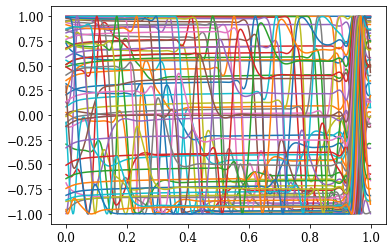

The algorithm converged to the desired accuracy. 570 38.52805884999998


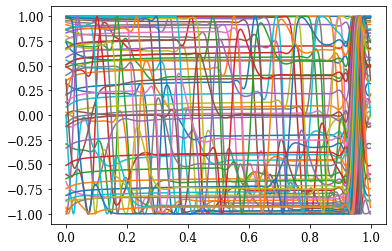

In [19]:
minds=find_peaks(phases[:,0])[0]

p0=order[0,minds[-2]]-order[0,minds[-8]]
Xts0=phases[minds[-8]:minds[-2]].T.copy()
ts0=(order[0,minds[-8]:minds[-2]]-order[0,minds[-8]])/p0
print(Xts0.shape,p0)
plt.plot(ts0,np.transpose(Xts0))
plt.show()

start=timeit.default_timer()
sol0=solve_bvp(lambda ts,Xts,p: p[0]*np.transpose([janusrot.janusrot(p[0]*ts[i],Xts[:,i], N, omega, sigma0, beta, gamma) for i in range(len(ts))]), lambda xa,xb,p: (np.concatenate((xb-xa,[(xa@xa)-(Xts0[:,0]@Xts0[:,0])]))), ts0, Xts0, p=np.array([p0]), max_nodes=10000,tol=1e0,bc_tol=1e-2)
stop=timeit.default_timer()
print(sol0.message,len(sol0.x),stop-start)
plt.plot(sol0.x,np.transpose(sol0.y))
plt.show()

### Naive continuation works. We can add bifurcation detection if we calculate Floquet exponents and continue snaking in principle.

In [ ]:
sols=[]
sigmas=[]
sol=sol0
start=timeit.default_timer()

sigma=sigma0
dsigma=0.5e-3
dsigmamax=1e-3
dsigmamin=1e-6
sigmamin=0.325
sigmamax=0.5
np.seterr(all='ignore')
count=0

while sol.success and sigma<sigmamax and sigma>sigmamin:
    #We could update the initial Xts and ts with an estimate based on Jacobian and dsigma (freezing the ts to the Xts value some way)
    sols.append(sol)
    sigmas.append(sigma)
    sigma=sigma+dsigma 
    p0=sol.p[0]
    try:
        sol=solve_bvp(lambda ts,Xts,p: p[0]*np.transpose([janusrot.janusrot(p[0]*ts[i],Xts[:,i], N, omega, sigma, beta, gamma) for i in range(len(ts))]), lambda xa,xb,p: (np.concatenate((xb-xa,[(xa@xa)-(Xts0[:,0]@Xts0[:,0])]))), ts0, Xts0, p=np.array([p0]), max_nodes=10000,tol=1e0,bc_tol=1e-2)

        if not sol.success:
            count=0
            print('f',end='')
            raise Exception(sol.message)
        count=count+1
        if len(sol.x)>1.25*len(sols[-1].x):
            print('m',end='')
            raise Exception('mesh increased too fast')
        if (np.abs(np.max(Xts0)-np.max(sol.y))/np.max(Xts0)>5e-1):
            print('c',end='')
            raise Exception('solution changed too much')
    except Exception as e:
        print('\n',str(e))
        sigma=sigma-dsigma
        dsigma=dsigma/2
        sol=sols[-1]
        if np.abs(dsigma)>dsigmamin:
            continue
        else:
            print('\nstep size too small')
            break
            
    if count>10:
        dsigma=np.sign(dsigma)*np.min([dsigmamax,np.abs(dsigma)*2])
        count=0
    print('\r%f\t%.3e\t%i\t%e\t'%(sigma, dsigma,len(sol.x),sol.p[0]-p0),end='')

    
stop=timeit.default_timer()
print('\n',sol.message,len(sols),len(sols[0].x),len(sols[-1].x),stop-start)
plt.plot(sol.x,np.transpose(sol.y))
plt.show()

0.352500	5.000e-04	570	3.064472e-01	m
 mesh increased too fast


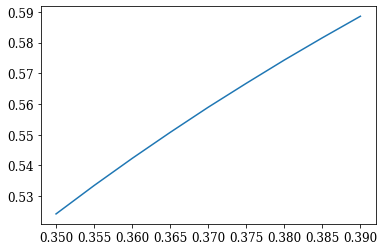

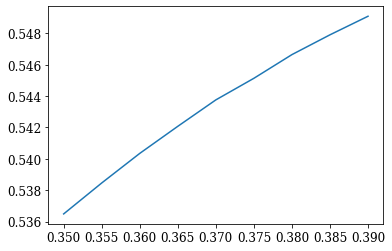

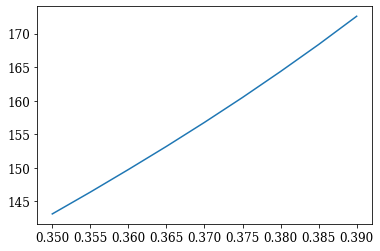

In [14]:
orders=[]
u0s=[]
periods=[]
for i in range(len(sols)):
    phases=sols[i].y.T.copy()
    r=np.abs(1+np.sum(phases[:,:N-1]+1j*phases[:,N-1:2*(N-1)],axis=1)+np.sum(phases[:,2*(N-1):2*(N-1)+N]+1j*phases[:,2*(N-1)+N:],axis=1))/(2*N)
    orders.append(np.mean(r))
    u0s.append(np.mean(phases[:,2*(N-1)]))
    periods.append(sols[i].p[0])
plt.plot(sigmas,u0s)
plt.show()
plt.plot(sigmas,orders)
plt.show()
plt.plot(sigmas,periods)
plt.show()